In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import sqlite3

In [4]:
# read usage data for a building from the database
conn = sqlite3.connect('../db.sqlite3')
usage_df = pd.read_sql_query("SELECT * FROM pma_usage WHERE property_name = 'Charles Shipman Payson Building' AND meter_type = 'Potable Indoor'", conn)
#print(usage_df.head())
usage_dates = ['-'.join((date.split(' ')[0]).split('-')[:-1]) for date in usage_df['start_date']]
usage = list(usage_df['common_usage_units'])

usage_dict, temps_dict = {}, {}

weather_df = pd.read_sql_query("SELECT * FROM pma_weather", conn)
weather_dates = ['-'.join((date.split(' ')[0]).split('-')[:-1]) for date in weather_df['date']]
temp = list(weather_df['temperature'])
#print(len(weather_dates), len(temp), weather_dates[:2], temp[:2])

for date, usg in zip(usage_dates, usage):
    usage_dict[date] = usg
for date, tmp in zip(weather_dates, temp):
    temps_dict[date] = tmp
conn.close()

# dates start at Feb-2012 and end at Sep-2022
print(usage_dates[0], usage_dates[-1])
print(weather_dates[0], weather_dates[-1])

2012-02 2022-09
2000-01 2023-12


In [5]:
# get usage and temperature for all the dates in usage_dict
monthly_usage, monthly_temp, dates = [], [], []
for date in usage_dict:
    if date in temps_dict:
        dates.append(date)
        monthly_usage.append(usage_dict[date])
        monthly_temp.append(temps_dict[date])

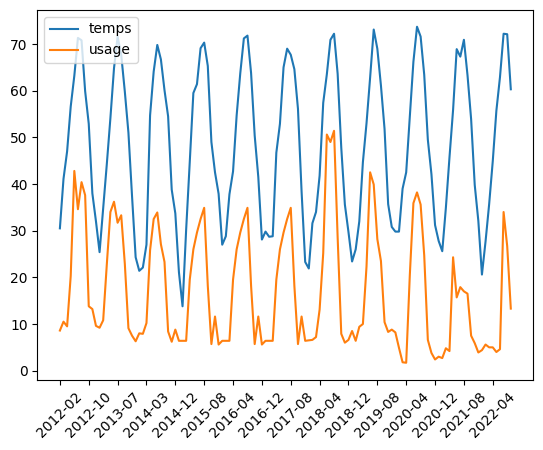

In [6]:
# plot temps; usage
# change the orientation of x axis legned to vertical
plt.plot(dates, monthly_temp, label='temps')
plt.xticks(dates[::8], rotation=45)
plt.plot(monthly_usage, label='usage')
plt.legend()
plt.show()

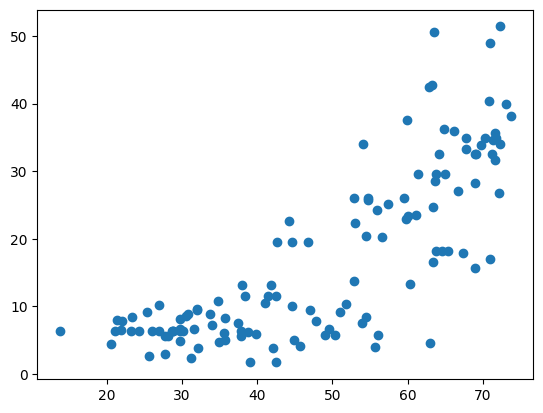

In [7]:
# plot temps on x, usage on y
plt.scatter(monthly_temp, monthly_usage)
plt.show()

In [8]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [9]:
model.fit(X=np.array(monthly_temp).reshape(-1, 1), y=np.array(monthly_usage))

LinearRegression()

In [11]:
last_month = dates[-1]
weather_dates.sort()
last_month_ind = weather_dates.index(last_month)
#print(weather_dates)
next_months = weather_dates[last_month_ind+1:]
next_months = next_months[:min(6, len(next_months))]
full_dates = dates + next_months
print(next_months)

next_temps = [temps_dict[date] for date in next_months]
new_usage = model.predict(np.array(next_temps).reshape(-1, 1))
total_usage = np.concatenate((monthly_usage, new_usage))
total_temps = np.concatenate((monthly_temp, next_temps))

['2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03']


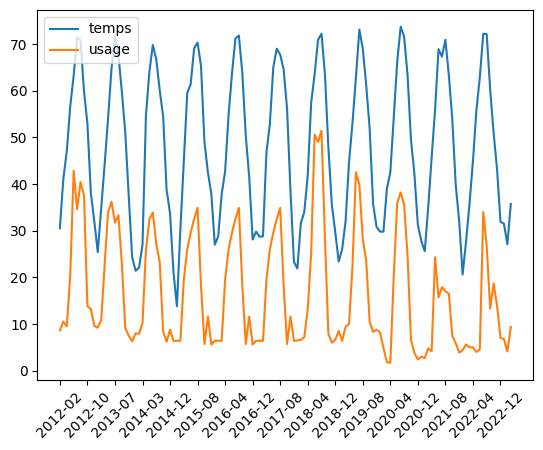

In [12]:
# plot new usage and temps
plt.plot(full_dates, total_temps, label='temps')
plt.plot(full_dates, total_usage, label='usage')
plt.xticks(full_dates[::8], rotation=45)
plt.legend()
plt.show()

In [19]:
# Update the database with new usage
conn = sqlite3.connect('../db.sqlite3')
c = conn.cursor()
# create a new table predict_usage in the database, replace if exists
c.execute("CREATE TABLE IF NOT EXISTS predict_usage (property_name TEXT, meter_type TEXT, date TEXT, temp REAL, usage REAL)")

for date, temp, usage in zip(next_months, next_temps, new_usage):
    c.execute("INSERT INTO predict_usage VALUES ('Charles Shipman Payson Building', 'Potable Indoor', ?, ?, ?)", (date, temp, usage))
conn.commit()
conn.close()